## Classify TinyImageNet30 images using a CNN model

In [1]:
import math
import torch
import os
import torch.nn as nn
import numpy as np
import torch.optim as optim
import torchvision
from PIL import Image
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import random
import torchvision.transforms as transforms
from torch.hub import load_state_dict_from_url
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader,random_split
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import confusion_matrix,roc_curve, roc_auc_score

In [2]:
# check if gpu/cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
device = 'cuda'

Using device: cpu


### **Overview:**

**1. Function implementation**

*   **1.1** PyTorch ```Dataset``` and ```DataLoader``` classes
*   **1.2** PyTorch ```Model``` class for a simple MLP model
*   **1.3** PyTorch ```Model``` class for a simple CNN model

**2. Model training** 
*   **2.1** Train on TinyImageNet30 dataset
*   **2.2** Generate confusion matrices and ROC curves
*   **2.3** Strategies for tackling overfitting
    *   **2.3.1** Data augmentation
    *   **2.3.2** Dropout
    *   **2.3.3** Hyperparameter tuning (e.g. changing learning rate)
            

**3. Model Fine-tuning on CIFAR10 dataset**
*   **3.1** Fine-tune CNN model (initialise model with pretrained weights from)
*   **3.2** Fine-tune model with frozen base convolution layers.
*   **3.3** Compare complete model retraining with pretrained weights and with frozen layers.

**4. Model comparison**
*   **4.1**   Load pretrained AlexNet and finetune on TinyImageNet30 until model convergence
*   **4.2**   Compare the results of my CNN model with pretrained AlexNet on the same validation set. Provide performance values (loss graph, confusion matrix, top-1 accuracy, execution time)

**5. Interpretation of results**
*   **6.1** Use grad-CAM on my CNN model and on AlexNet
*   **6.2** Visualise and compare the results from your model and from AlexNet
*   **6.3** Comment on:
    - why the network predictions were correct or not correct? 
    - what can we do to improve my results further?

## 1 Function implementations
### 1.1 Dataset class

In [4]:
from functools import total_ordering
class MyDataset(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        self.total_imgs = []
        self.all_imgs = []

        # get pathes of all images
        for root, _, files in os.walk(main_dir):
            for file in files:
                if file.endswith('.JPEG'):
                    self.total_imgs.append(os.path.join(root, file))
        self.mapping = {'baboon': 0, 'banana': 1, 'bee': 2, 'bison': 3, 
                        'butterfly': 4, 'candle': 5, 'cardigan': 6, 'chihuahua': 7, 
                        'elephant': 8, 'espresso': 9, 'fly': 10, 'goldfish': 11, 
                        'goose': 12, 'grasshopper': 13, 'hourglass': 14, 'icecream': 15, 
                        'ipod': 16, 'jellyfish': 17, 'koala': 18, 'ladybug': 19, 
                        'lion': 20, 'mushroom': 21, 'penguin': 22, 'pig': 23, 
                        'pizza': 24, 'pretzel': 25, 'redpanda': 26, 'refrigerator': 27, 
                        'sombrero': 28, 'umbrella': 29}

    def __len__(self):
        return len(self.total_imgs)
    
    def __getitem__(self, idx):
        img_loc = self.total_imgs[idx]
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        label = img_loc.split('/')[-2]
        label = self.mapping[label]
        tensor_image = (tensor_image, label)
        return tensor_image

    # load dataset in advance
    def __getAll__(self):
        all = []
        for img_loc in self.total_imgs:
          i = i + 1
          image = Image.open(img_loc).convert("RGB")
          tensor_image = self.transform(image)
          label = img_loc.split('/')[-2]
          label = self.mapping[label]
          tensor_image = (tensor_image, label)
          all.append(tensor_image)
        return all

In [5]:
# load dataset
main_dir = "/kaggle/input/comp5623m-artificial-intelligence/train_set/train_set/train_set"
transform = transforms.ToTensor()
dataset = MyDataset(main_dir = main_dir, transform = transform)

# use seed 0 to split the dataset for train and validation
random.seed(0)
np.random.seed(0)

dataset_size = len(dataset)
val_size = int(0.2 * dataset_size)
train_size = dataset_size - val_size
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])

batch_size = 16
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)



ValueError: num_samples should be a positive integer value, but got num_samples=0

### 1.2 Define a MLP model class
- Input Units
- Hidden Units
- Output Units
- Activation functions

In [12]:
class MyMLP(nn.Module):
    def __init__(self):
        super(MyMLP, self).__init__()
        
        self.fc1 = nn.Linear(64*64*3, 256)
        self.relu1 = nn.ReLU()
        
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        
        self.fc3 = nn.Linear(128, 30)
        
        self.lossfunction = nn.CrossEntropyLoss()
        self.optimizer = optim.SGD(self.parameters(), lr=0.001, momentum=0.9)
        
    def forward(self, x):
        x = x.view(-1, 64*64*3)
        x = self.fc1(x)
        x = self.relu1(x)
        
        x = self.fc2(x)
        x = self.relu2(x)
        
        x = self.fc3(x)
        
        return x

### 1.3 Define a CNN model class
- Convolution layers
- Activation functions (e.g. ReLU)
- Maxpooling layers
- Fully connected layers

In [13]:
# 1.3 PyTorch Model class for a simple CNN model
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 13 * 13, 256)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(256, 30)

        self.lossfunction = nn.CrossEntropyLoss()
        self.optimizer = optim.SGD(self.parameters(), lr=0.001, momentum=0.9)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        
        return x

    

In [55]:
# function of plot loss, accuracy
class myPlot():
    def __init__(self, path, tit):
        self.path =  path
        self.title = tit
    
    def plot(self):
        data = torch.load(self.path)
        statsrec = data["stats"]
        fig, ax1 = plt.subplots()
        plt.plot(statsrec[0], 'r', label = 'training loss', )
        plt.plot(statsrec[2], 'g', label = 'test loss' )
        plt.legend(loc='lower right')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.title(self.title)
        ax2=ax1.twinx()
        ax2.plot(statsrec[1], 'm', label = 'training accuracy')
        ax2.plot(statsrec[3], 'b', label = 'test accuracy')
        ax2.set_ylabel('accuracy')
        plt.legend(loc='upper right')
        # fig.savefig("roc.svg")
        plt.show()

## 2 Model training [20 marks]


### 2.1 Train both MLP and CNN models - show loss and accuracy graphs side by side [7 marks]

Train your model on the TinyImageNet30 dataset. Split the data into train and validation sets to determine when to stop training. Use seed at 0 for reproducibility and test_ratio=0.2 (validation data)

Display the graph of training and validation loss over epochs and accuracy over epochs to show how you determined the optimal number of training epochs. Top-*k* accuracy implementation is provided for you below.

> Please leave the graph clearly displayed. Please use the same graph to plot graphs for both train and validation.


In [15]:
def stats(loader, net):
    correct = 0
    total = 0
    running_loss = 0
    n = 0   
    net = net.to(device)
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = net(images)      
            
            # accumulate loss
            running_loss += loss_fn(outputs, labels)
            n += 1
            
            # accumulate data for accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)    # add in the number of labels in this minibatch
            correct += (predicted == labels).sum().item()  # add in the number of correct labels
            
    return running_loss/n, correct/total


In [16]:
# Define top-*k* accuracy 
def topk_accuracy(output, target, topk=(1,)):
#     """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


In [17]:
# training function
class Trainer:
    def __init__(self, model, train_loader, val_loader, optimizer, loss_fn, results_path):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.results_path = results_path
        
    def train(self, nepochs):
        statsrec = np.zeros((4, nepochs))
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model.to(device)

        for epoch in range(nepochs):
            correct = 0          # number of examples predicted correctly (for accuracy)
            total = 0            # number of examples
            running_loss = 0.0   # accumulated loss (for mean loss)
            n = 0                # number of minibatches

            for data in self.train_loader:
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                self.optimizer.zero_grad()

                # Forward, backward, and update parameters
                outputs = self.model(inputs)
                loss = self.loss_fn(outputs, labels)
                loss.backward()
                self.optimizer.step()
        
                # accumulate loss
                running_loss += loss.item()
                n += 1

                # accumulate data for accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)    # add in the number of labels in this minibatch
                correct += (predicted == labels).sum().item()  # add in the number of correct labels

            # collect together statistics for this epoch
            ltrn = running_loss/n
            atrn = correct/total 
            # modified to store vtl, vpl
            ltst, atst = self.stats(self.val_loader, self.model)

            statsrec[:,epoch] = (ltrn, atrn, ltst, atst)

            print(f"epoch: {epoch} training loss: {ltrn: .3f} training accuracy: {atrn: .1%}  test loss: {ltst: .3f} test accuracy: {atst: .1%}")

        torch.save({"state_dict": self.model.state_dict(), "stats": statsrec}, self.results_path)

    def stats(self, dataloader, model):
        correct = 0
        total = 0
        loss = 0.0
        n = 0
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        with torch.no_grad():
            for data in dataloader:
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss += self.loss_fn(outputs, labels).item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                n += 1

        loss /= n
        acc = correct/total

        return loss, acc

In [18]:
#TO COMPLETE --> Running you MLP model class
myMLP = MyMLP().to(device)
nepochs = 50
results_path = "/kaggle/working/" + 'mlp_50.pt'
statsrec = np.zeros((4,nepochs))


optimizer = myMLP.optimizer
loss_fn = myMLP.lossfunction

trainer = Trainer(myMLP, train_loader, val_loader, optimizer, loss_fn, results_path)
trainer.train(nepochs)

epoch: 0 training loss:  3.289 training accuracy:  8.6%  test loss:  3.167 test accuracy:  11.6%
epoch: 1 training loss:  3.073 training accuracy:  13.1%  test loss:  3.049 test accuracy:  13.0%
epoch: 2 training loss:  2.937 training accuracy:  16.0%  test loss:  2.927 test accuracy:  15.9%
epoch: 3 training loss:  2.853 training accuracy:  18.2%  test loss:  2.917 test accuracy:  17.7%
epoch: 4 training loss:  2.797 training accuracy:  19.7%  test loss:  2.829 test accuracy:  20.4%
epoch: 5 training loss:  2.733 training accuracy:  21.3%  test loss:  2.797 test accuracy:  20.7%
epoch: 6 training loss:  2.676 training accuracy:  22.8%  test loss:  2.805 test accuracy:  20.3%
epoch: 7 training loss:  2.639 training accuracy:  24.1%  test loss:  2.760 test accuracy:  20.5%
epoch: 8 training loss:  2.586 training accuracy:  25.7%  test loss:  2.809 test accuracy:  20.1%
epoch: 9 training loss:  2.536 training accuracy:  26.7%  test loss:  2.756 test accuracy:  22.2%
epoch: 10 training lo

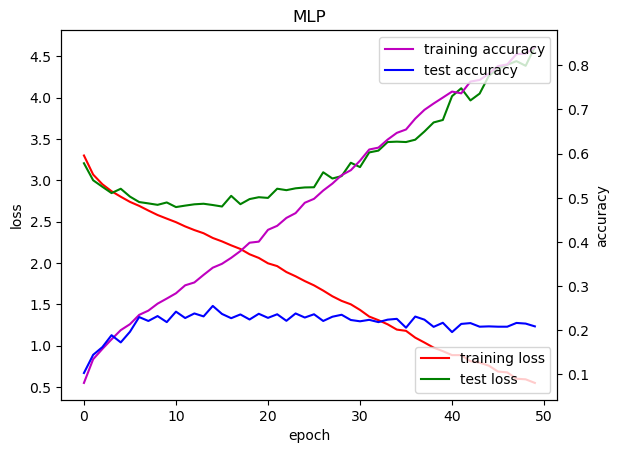

In [56]:
# Your graph
mlp = MyMLP()
results_path = "/kaggle/input/mymodels/mlp_50.pt"

checkpoint = torch.load(results_path)
mlp.load_state_dict(checkpoint['state_dict'])
optimizer = mlp.optimizer
myplot = myPlot(results_path,"MLP")
myplot.plot()

In [20]:
#TO COMPLETE --> Running you CNN model class
myCNN = MyCNN().to(device)
nepochs = 30
results_path = "/kaggle/working/" + 'testcnn30_new.pt'
statsrec = np.zeros((4,nepochs))


optimizer = myCNN.optimizer
loss_fn = myCNN.lossfunction

trainer = Trainer(myCNN, train_loader, val_loader, optimizer, loss_fn, results_path)
trainer.train(nepochs)


epoch: 0 training loss:  3.389 training accuracy:  5.4%  test loss:  3.333 test accuracy:  6.7%
epoch: 1 training loss:  3.159 training accuracy:  10.9%  test loss:  3.060 test accuracy:  13.6%
epoch: 2 training loss:  2.996 training accuracy:  15.3%  test loss:  2.979 test accuracy:  15.4%
epoch: 3 training loss:  2.906 training accuracy:  17.4%  test loss:  2.914 test accuracy:  17.7%
epoch: 4 training loss:  2.789 training accuracy:  20.7%  test loss:  2.789 test accuracy:  21.7%
epoch: 5 training loss:  2.670 training accuracy:  24.0%  test loss:  2.819 test accuracy:  20.0%
epoch: 6 training loss:  2.560 training accuracy:  26.8%  test loss:  2.657 test accuracy:  24.8%
epoch: 7 training loss:  2.453 training accuracy:  29.4%  test loss:  2.563 test accuracy:  26.5%
epoch: 8 training loss:  2.328 training accuracy:  32.6%  test loss:  2.510 test accuracy:  28.8%
epoch: 9 training loss:  2.224 training accuracy:  35.8%  test loss:  2.467 test accuracy:  30.6%
epoch: 10 training los

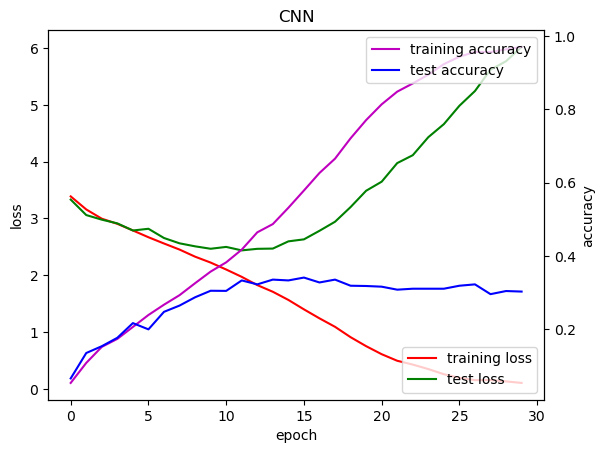

In [57]:
# Your graph
myCNN = MyCNN()
results_path = "/kaggle/working/testcnn30_new.pt"

checkpoint = torch.load(results_path)
myCNN.load_state_dict(checkpoint['state_dict'])
optimizer = myCNN.optimizer
myplot = myPlot(results_path,"CNN")
myplot.plot()

In [17]:
total_params_cnn = sum(p.numel() for p in myCNN.parameters())
print(f"Total number of parameters: {total_params_cnn}")

total_params_mlp = sum(p.numel() for p in mlp.parameters())
print(f"Total number of parameters: {total_params_mlp}")

Total number of parameters: 704014
Total number of parameters: 3182750


> Comment on your model and results that should include number of parameters in each model and why CNN over MLP for image classification task?

In this case, I can tell even MLP model has more parameters than CNN model's. CNN still works better than MLP. The crucial point is CNNs use convolutional neurons(layers) which are designed to be sensitive to specific local patterns in the input. Moreover, the pooling layers help CNNs achive translation invariant, which allows CNNs recognise the objective in any specific position of the image.
In contrast, the MLPs do not have connectivity or translation invariant. MLPs more suitbale to vector input.


### 2.2 Generating confusion matrix and ROC curves [4 marks]
- Use your CNN architecture with best accuracy to generate two confusion matrices, one for the training set and another for the validation set. Remember to use the whole validation and training sets, and to include all your relevant code. Display the confusion matrices in a meaningful way that clearly indicates what percentage of the data is represented in each position.
- Display ROC curve for 5 top classes with area under the curve

In [22]:
# Your code here!
model = MyCNN()
results_path = "/kaggle/working/testcnn30_new.pt"
checkpoint = torch.load(results_path)
model.load_state_dict(checkpoint['state_dict'])
model.eval()

MyCNN(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2704, out_features=256, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=256, out_features=30, bias=True)
  (lossfunction): CrossEntropyLoss()
)

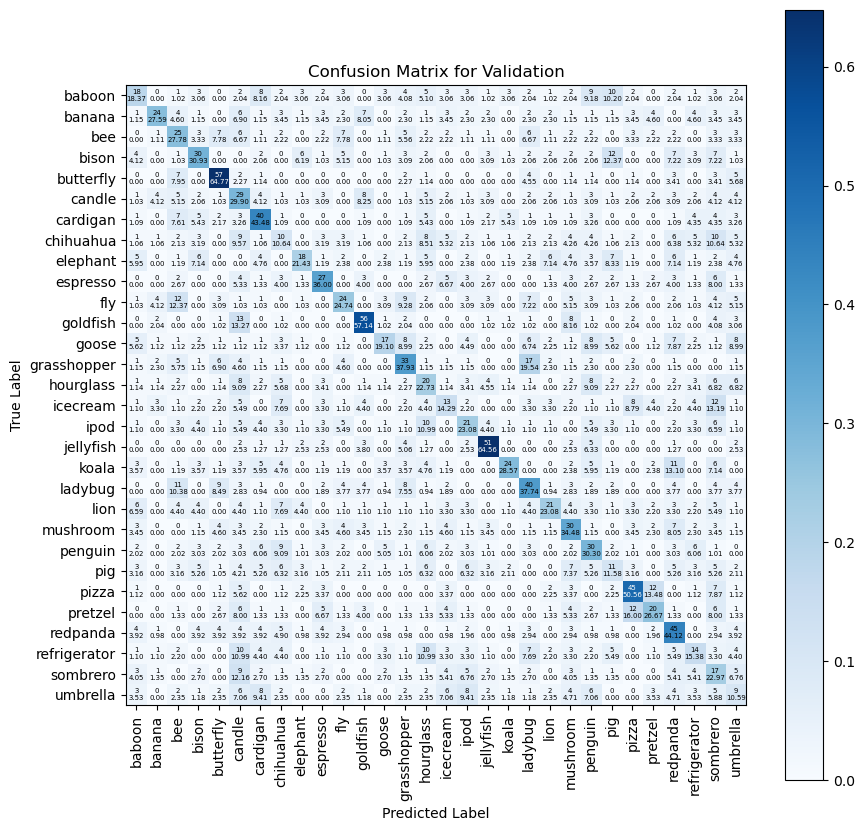

In [23]:
# confusion matrix -- validation
classes = ['baboon', 'banana', 'bee', 'bison', 'butterfly', 'candle', 'cardigan', 'chihuahua', 'elephant', 'espresso', 'fly', 'goldfish', 'goose', 'grasshopper', 'hourglass', 'icecream', 'ipod', 'jellyfish', 'koala', 'ladybug', 'lion', 'mushroom', 'penguin', 'pig', 'pizza', 'pretzel', 'redpanda', 'refrigerator', 'sombrero', 'umbrella']
# Initialize lists to store true and predicted labels
y_true = []
y_pred = []

model = model.to(device)

# Make predictions on the validation set and collect the true and predicted labels
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cm_norm, cmap='Blues')

cbar = ax.figure.colorbar(im, ax=ax)


ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes, rotation=90)
ax.set_yticklabels(classes)


for i in range(len(classes)):
    for j in range(len(classes)):
        ax.text(j, i, format(cm[i, j], 'd')+'\n'+format(cm_norm[i, j]*100, '.2f'),
                ha="center", va="center", fontsize=5, color="white" if cm_norm[i, j] > 0.5 else "black")

# Set axis labels and title
ax.set_title("Confusion Matrix for Validation")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

# Display the plot
plt.show()


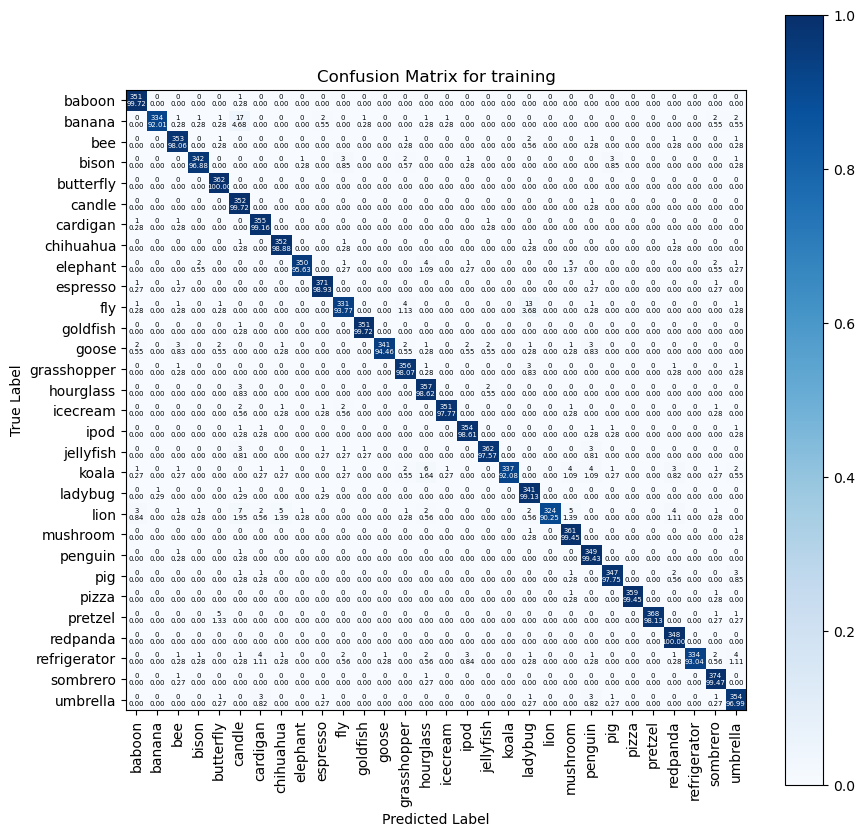

In [24]:
# confusion matrix -- training
classes = ['baboon', 'banana', 'bee', 'bison', 'butterfly', 'candle', 'cardigan', 'chihuahua', 'elephant', 'espresso', 'fly', 'goldfish', 'goose', 'grasshopper', 'hourglass', 'icecream', 'ipod', 'jellyfish', 'koala', 'ladybug', 'lion', 'mushroom', 'penguin', 'pig', 'pizza', 'pretzel', 'redpanda', 'refrigerator', 'sombrero', 'umbrella']

y_true = []
y_pred = []

# Make predictions on the validation set and collect the true and predicted labels
with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())


cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10, 10))

im = ax.imshow(cm_norm, cmap='Blues')


cbar = ax.figure.colorbar(im, ax=ax)

ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes, rotation=90)
ax.set_yticklabels(classes)

# Loop over data dimensions and create text annotations.
for i in range(len(classes)):
    for j in range(len(classes)):
        ax.text(j, i, format(cm[i, j], 'd')+'\n'+format(cm_norm[i, j]*100, '.2f'),
                ha="center", va="center", fontsize=5, color="white" if cm_norm[i, j] > 0.5 else "black")

# Set axis labels and title
ax.set_title("Confusion Matrix for training")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")


plt.show()


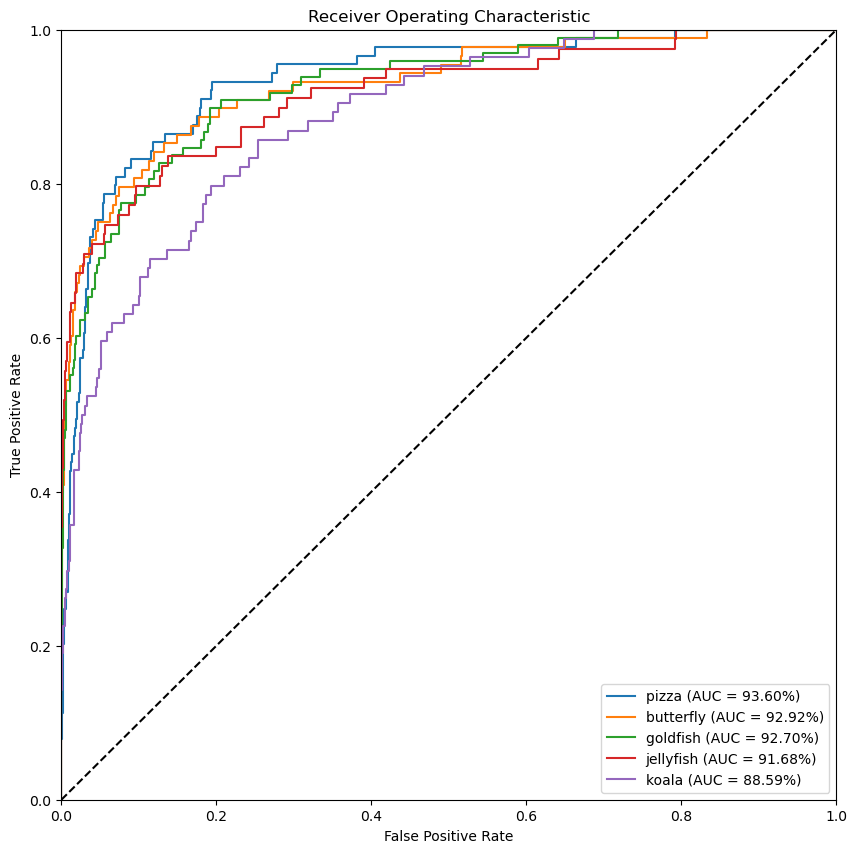

In [25]:
from sklearn.metrics import roc_curve, auc
y_true = []
y_pred_prob = []

# Iterate over the validation set and store the true labels and predicted probabilities
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred_prob.extend(probs.cpu().numpy())

# Convert the lists to numpy arrays
y_true = np.array(y_true)
y_pred_prob = np.array(y_pred_prob)

# Compute the ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
num_classes = 30
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves for the top 5 classes with the highest AUC
plt.figure(figsize=(10, 10))
plt.title('Receiver Operating Characteristic')
for i in np.argsort(list(roc_auc.values()))[::-1][:5]:
    plt.plot(fpr[i], tpr[i], label='{} (AUC = {:.2f}%)'.format(classes[i], roc_auc[i]*100))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

**Note: All parts below here relate to the CNN model only and not the MLP! You are advised to use your final CNN model only for each of the following parts.**

### 2.3 Strategies for tackling overfitting (9 marks)
Using your (final) CNN model, use the strategies below to avoid overfitting. You can reuse the network weights from previous training, often referred to as ``fine tuning``. 
*   **2.3.1** Data augmentation
*   **2.3.2** Dropout
*   **2.3.3** Hyperparameter tuning (e.g. changing learning rate)

Plot loss and accuracy graphs per epoch side by side for each implemented strategy.

#### 2.3.1 Data augmentation

> Implement at least five different data augmentation techniques that should include both photometric and geometric augmentations. 

> Provide graph and comment on what you observe


After applying augmentation techniques, overfitting can be greatly reduced and there is an improvement in accuracy as well.   
The reason is, by applying various transformations to the original images, the model can be exposed to a wider range of data, making it more robust to variations in the input. By generating new variations of the training data, the model is less likely to memorize the training data and more likely to learn the underlying patterns in the data.

In [33]:
import torchvision.transforms as transforms
# Load model
model = MyCNN()
results_path = "/kaggle/input/mymodels/testcnn50_new.pt"

checkpoint = torch.load(results_path)
myCNN.load_state_dict(checkpoint['state_dict'])


# augmentation
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(64),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# load dataset again
main_dir = "/kaggle/input/comp5623m-artificial-intelligence/train_set/train_set/train_set"
dataset = MyDataset(main_dir = main_dir, transform = transform)

dataset_size = len(dataset)

train_size = int(0.8 * dataset_size)
val_size = dataset_size  - train_size
train_set,val_set = torch.utils.data.random_split(dataset, [train_size,val_size])

# apply transformation to train set
train_set.transform = transform_train

# apply transformation to val set
val_set.transform = transform_val

batch_size = 16
train_loader_aug = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle=True)
val_loader_aug = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)

# train
nepochs = 30
results_path = "/kaggle/working/cnn_agu50.pt"

optimizer = model.optimizer
loss_fn = model.lossfunction

trainer = Trainer(model, train_loader_aug, val_loader_aug, optimizer, loss_fn, results_path)
trainer.train(nepochs)



epoch: 0 training loss:  3.389 training accuracy:  4.9%  test loss:  3.339 test accuracy:  8.5%
epoch: 1 training loss:  3.151 training accuracy:  11.4%  test loss:  3.022 test accuracy:  15.1%
epoch: 2 training loss:  2.937 training accuracy:  16.8%  test loss:  2.914 test accuracy:  18.2%
epoch: 3 training loss:  2.798 training accuracy:  20.5%  test loss:  2.764 test accuracy:  20.3%
epoch: 4 training loss:  2.681 training accuracy:  23.3%  test loss:  2.663 test accuracy:  23.3%
epoch: 5 training loss:  2.573 training accuracy:  26.6%  test loss:  2.603 test accuracy:  25.8%
epoch: 6 training loss:  2.455 training accuracy:  29.1%  test loss:  2.629 test accuracy:  24.2%
epoch: 7 training loss:  2.332 training accuracy:  32.5%  test loss:  2.495 test accuracy:  29.3%
epoch: 8 training loss:  2.205 training accuracy:  36.6%  test loss:  2.481 test accuracy:  29.1%
epoch: 9 training loss:  2.082 training accuracy:  39.1%  test loss:  2.401 test accuracy:  32.0%
epoch: 10 training los

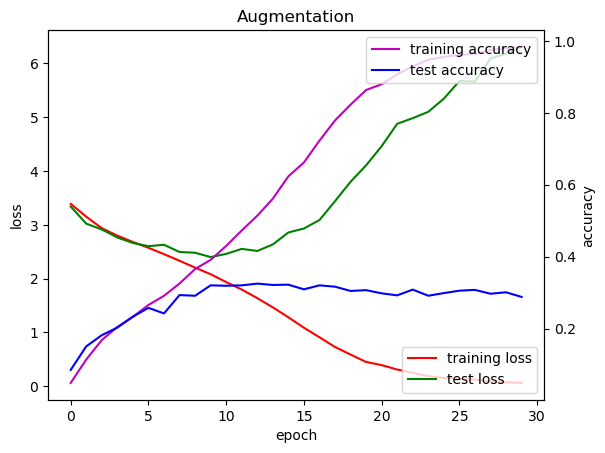

In [58]:
# plot
myCNN = MyCNN()
results_path = "/kaggle/working/cnn_agu50.pt"

checkpoint = torch.load(results_path)
myCNN.load_state_dict(checkpoint['state_dict'])
optimizer = myCNN.optimizer
myplot = myPlot(results_path,"Augmentation")
myplot.plot()

#### 2.3.2 Dropout

> Implement dropout in your model 

> Provide graph and comment on your choice of proportion used

Based on my experiments, I found that dropout does help to reduce overfitting in the model, but it did not result in a significant improvement in accuracy.

In [35]:
# add dropout
class MyCNN_drop(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(MyCNN_drop, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 13 * 13, 256)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(256, 30)

        self.lossfunction = nn.CrossEntropyLoss()
        self.optimizer = optim.SGD(self.parameters(), lr=0.001, momentum=0.9)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [36]:
# train 
results_path = "/kaggle/working/" + 'cnn_dropout.pt'

myCNN = MyCNN_drop()
optimizer = myCNN.optimizer
loss_fn = myCNN.lossfunction

nepochs = 30
trainer = Trainer(myCNN, train_loader, val_loader, optimizer, loss_fn, results_path)
trainer.train(nepochs)


epoch: 0 training loss:  3.397 training accuracy:  4.1%  test loss:  3.378 test accuracy:  5.3%
epoch: 1 training loss:  3.255 training accuracy:  8.7%  test loss:  3.157 test accuracy:  11.1%
epoch: 2 training loss:  3.100 training accuracy:  12.2%  test loss:  3.094 test accuracy:  12.4%
epoch: 3 training loss:  3.035 training accuracy:  14.0%  test loss:  3.107 test accuracy:  12.4%
epoch: 4 training loss:  2.983 training accuracy:  14.7%  test loss:  3.025 test accuracy:  13.4%
epoch: 5 training loss:  2.934 training accuracy:  16.9%  test loss:  2.978 test accuracy:  14.9%
epoch: 6 training loss:  2.899 training accuracy:  17.6%  test loss:  2.977 test accuracy:  15.4%
epoch: 7 training loss:  2.839 training accuracy:  19.0%  test loss:  2.889 test accuracy:  17.5%
epoch: 8 training loss:  2.761 training accuracy:  20.9%  test loss:  2.856 test accuracy:  19.1%
epoch: 9 training loss:  2.693 training accuracy:  22.5%  test loss:  2.795 test accuracy:  19.6%
epoch: 10 training loss

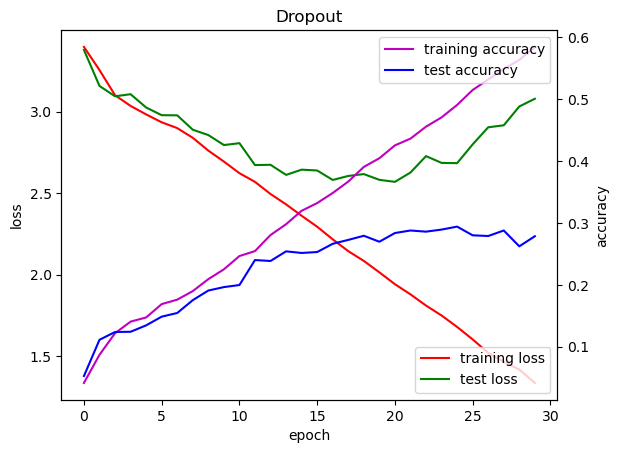

In [59]:
# plot
myCNN = MyCNN()
results_path = "/kaggle/working/cnn_dropout.pt"

checkpoint = torch.load(results_path)
myCNN.load_state_dict(checkpoint['state_dict'])
optimizer = myCNN.optimizer
myplot = myPlot(results_path,"Dropout")
myplot.plot()

#### 2.3.3 Hyperparameter tuning

> Use learning rates [0.1, 0.001, 0.0001]

> Provide separate graphs for loss and accuracy, each showing performance at three different learning rates

If the learning rate is too high, the model may converge quickly, leading to low accuracy. On the other hand, a low learning rate may cause the model to converge very slowly and sometimes even get stuck in a local minimum. That is why 0.001 is better than 0.0001 and 0.1.

In [ ]:
# Actually 0.001 has already exist, cnn_agu_dropout is 
cnn_Drop = MyCNN_drop()
root = "/kaggle/working/"
LR = [0.1, 0.0001]
results_path = "cnn_dropout_" + str(LR[0])
print(results_path)
optimizer = optim.SGD(cnn_Drop.parameters(), lr=LR[0], momentum=0.9)
loss_fn = cnn_Drop.lossfunction

nepochs = 50
trainer = Trainer(cnn_Drop, train_loader, val_loader, optimizer, loss_fn, results_path)
trainer.train(nepochs)

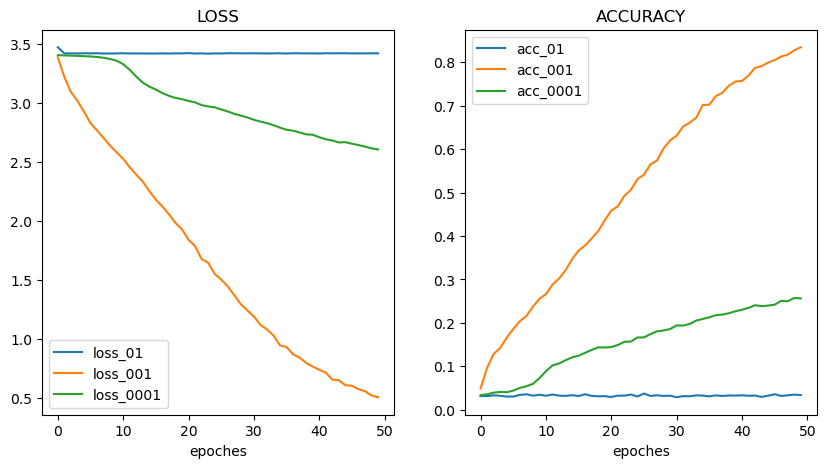

In [31]:
# lr_0001  0loss 1acc
results_path = "/kaggle/input/mymodels/cnn_dropout_0.0001.pt"
checkpoint = torch.load(results_path)
statsrec0001 = checkpoint["stats"]


# lr_01
results_path = "/kaggle/input/mymodels/cnn_dropout_0.01.pt"
checkpoint = torch.load(results_path)
statsrec01 = checkpoint["stats"]

# lr_001
results_path = "/kaggle/input/mymodels/cnn_dropout_new.pt"
checkpoint = torch.load(results_path)
statsrec001 = checkpoint["stats"]

# plot
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(statsrec01[0], label='loss_01')
axs[0].plot(statsrec001[0], label='loss_001')
axs[0].plot(statsrec0001[0], label='loss_0001')


axs[0].set_title('LOSS')
axs[0].set_xlabel('epoches')
# axs[0].set_ylabel('Y-axis label')
axs[0].legend()

axs[1].plot(statsrec01[1], label='acc_01')
axs[1].plot(statsrec001[1], label='acc_001')
axs[1].plot(statsrec0001[1], label='acc_0001')

axs[1].set_title('ACCURACY')
axs[1].set_xlabel('epoches')
axs[1].legend()

plt.show()

### 3 Model testing [18 marks]
Online evaluation of your model performance on the test set.

> Prepare the dataloader for test set

> Write evaluation code for writing predictions

> Upload it to Kaggle submission page [link](https://www.kaggle.com/t/917fe52f6a3c4855880a24b34f26db07) 


#### 3.1 Test class and predictions [10 marks]

> Build a test class, prepare a test dataloader and generate predictions 

Create a PyTorch ```Dataset``` for the unlabeled test data in the test_set folder of the Kaggle competition and generate predictions using your final model. Test data can be downloaded [here](https://www.kaggle.com/competitions/comp5623m-artificial-intelligence/data?select=test_set)

In [38]:
!pip install natsort

#### 3.2 Prepare your submission and upload to Kaggle [8 marks]

Save all test predictions to a CSV file and submit it to the private class Kaggle competition. **Please save your test CSV file submissions using your student username (the one with letters, ie., ``sc15jb``, not the ID with only numbers)**, for example, `sc15jb.csv`. That will help us to identify your submissions.

The CSV file must contain only two columns: ‘Id’ and ‘Category’ (predicted class ID) as shown below:

```txt
Id,Category
28d0f5e9_373c.JPEG,2
bbe4895f_40bf.JPEG,18
```

Please note you will get marks for higher performance.

The ‘Id’ column should include the name of the image. It is important to keep the same name as the one on the test set. Do not include any path, just the name of file (with extension). Your csv file must contain 1501 rows, one for each image in the test set and 1 row for the headers. [To submit please visit](https://www.kaggle.com/t/917fe52f6a3c4855880a24b34f26db07)

> You may submit multiple times. We will use your personal top entry for allocating marks for this [8 marks]. The class leaderboard will not affect marking (brownie points!).


In [75]:
# Your code here! 
from functools import total_ordering
from natsort import natsorted
# TO COMPLETE
class LoadFromFolder(Dataset):
    def __init__(self, main_dir, transform):
      # Set the loading directory
        self.main_dir = main_dir
        self.transform = transform
        self.total_imgs = []

        # List all images in folder and count them
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsorted(all_imgs)

        
      # count them
    def __len__(self):
        return len(self.total_imgs)
    
    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
     
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image


batch_size = 16
transform0 = transforms.Compose([
    transforms.ToTensor()
])
test_data = LoadFromFolder(main_dir = "/kaggle/input/comp5623m-artificial-intelligence/test_set/test_set/test_set", transform = transform0)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


In [ ]:
# load model
model = MyCNN()
results_path = "/kaggle/input/mymodels/cnn_agu50_new.pt"
checkpoint = torch.load(results_path)
model.load_state_dict(checkpoint['state_dict'])
model.eval()

model.to(device)
model.eval()
predictions = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())

# Create a dictionary with the predictions and image filenames
result_dict = {'Id': test_data.total_imgs, 'Category': predictions}
result_df = pd.DataFrame(result_dict)
result_df.to_csv('/kaggle/working/ml21s2j.csv', index=False)


### 4 Model Fine-tuning/transfer learning on CIFAR10 dataset  [20 marks]

Fine-tuning is a way of applying or utilizing transfer learning. It is a process that takes a model that has already been trained for one task and then tunes or tweaks the model to make it perform a second similar task. You can perform finetuning in the following way:
- Train an entire model from scratch (large dataset, more computation)
- Freeze convolution base and train only last FC layers (small dataset and lower computation) 

> **Configuring your dataset**
   - Download your dataset using ``torchvision.datasets.CIFAR10``, [explained here](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html)
   - Split training dataset into training and validation set similar to above. *Note that the number of categories here are only 10*


In [39]:
# Your code here! 
ROOT = "/kaggle/working/"

# Load the datasets
dataset = torchvision.datasets.CIFAR10(
    root=ROOT+'cifar',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

dataset_size = len(dataset)

# cifar 10
train_size = int(0.8 * dataset_size)
val_size = dataset_size  - train_size
train_set,val_set = torch.utils.data.random_split(dataset, [train_size,val_size])
batch_size = 16
train_loader_cifar = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle=True)
val_loader_cifar = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)

classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /kaggle/working/cifar/cifar-10-python.tar.gz to /kaggle/working/cifar


> Load pretrained AlexNet from PyTorch - use model copies to apply transfer learning in different configurations

In [40]:
# Your code here! 
import torchvision.models as models
alexnet = models.alexnet(pretrained=True)

# Replace the final fully connected layer
num_classes = 10 
alexnet.features[0] = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=2)
num_features = alexnet.classifier[6].in_features
alexnet.classifier[6] = torch.nn.Linear(num_features, num_classes)

alexnet.eval()

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
   

#### 4.1 Apply transfer learning initialise with pretrained model weights
Use pretrained weights from AlexNet only (on the right of figure) to initialise your model. 

<img src="https://upload.wikimedia.org/wikipedia/commons/c/cc/Comparison_image_neural_networks.svg" style="width:1000px;height:400px;">
<caption><center> <u>Figure</u>: Two models are given here: LeNet and AlexNet for image classification. However, you have to use **only AlexNet**.</center></caption>


> Configuration 1: No frozen layers

In [41]:
# Your model changes here - also print trainable parameters
alexnet_c1 = alexnet
for param in alexnet_c1.parameters():
    param.requires_grad = True


# Print the total number of parameters
total_params = sum(p.numel() for p in alexnet_c1.parameters())
print(f"Total number of parameters: {total_params}")

# Print the number of trainable parameters
trainable_params = sum(p.numel() for p in alexnet_c1.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")
alexnet_c1.eval()

Total number of parameters: 57023306
Number of trainable parameters: 57023306


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
   

#### 4.2 Fine-tuning model with frozen layers

> Configuration 2: Frozen base convolution blocks

In [42]:
# Your changes here - also print trainable parameters
# Freeze the base convolutional layers
alexnet_c2 = alexnet
for param in alexnet_c2.features.parameters():
    param.requires_grad = False
# alexnet_c2.eval()
# Print the total number of parameters
total_params = sum(p.numel() for p in alexnet_c2.parameters())
print(f"Total number of parameters: {total_params}")

# Print the number of trainable parameters
trainable_params = sum(p.numel() for p in alexnet_c2.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")
alexnet_c2.eval()

Total number of parameters: 57023306
Number of trainable parameters: 54575114


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
   

#### 4.3 Compare above configurations and comment on comparative performance

In [43]:
nepochs = 30
results_path = "/kaggle/working/Alex_nofrozen.pt"

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(alexnet_c1.parameters(), lr=0.001, momentum=0.9)

trainer = Trainer(alexnet_c1, train_loader_cifar, val_loader_cifar, optimizer, loss_fn, results_path)
trainer.train(nepochs)

epoch: 0 training loss:  1.782 training accuracy:  34.9%  test loss:  1.635 test accuracy:  40.5%
epoch: 1 training loss:  1.595 training accuracy:  42.2%  test loss:  1.588 test accuracy:  43.5%
epoch: 2 training loss:  1.525 training accuracy:  44.9%  test loss:  1.518 test accuracy:  45.9%
epoch: 3 training loss:  1.482 training accuracy:  46.7%  test loss:  1.459 test accuracy:  47.0%
epoch: 4 training loss:  1.444 training accuracy:  48.1%  test loss:  1.430 test accuracy:  49.1%
epoch: 5 training loss:  1.412 training accuracy:  49.3%  test loss:  1.412 test accuracy:  49.4%
epoch: 6 training loss:  1.393 training accuracy:  50.2%  test loss:  1.400 test accuracy:  50.0%
epoch: 7 training loss:  1.367 training accuracy:  51.0%  test loss:  1.441 test accuracy:  48.4%
epoch: 8 training loss:  1.347 training accuracy:  51.6%  test loss:  1.361 test accuracy:  51.9%
epoch: 9 training loss:  1.327 training accuracy:  52.6%  test loss:  1.366 test accuracy:  50.7%
epoch: 10 training l

In [46]:
nepochs = 30
results_path = "/kaggle/working/Alex_partfrozen.pt"

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(alexnet_c2.parameters(), lr=0.001, momentum=0.9)

trainer = Trainer(alexnet_c2, train_loader_cifar, val_loader_cifar, optimizer, loss_fn, results_path)
trainer.train(nepochs)

epoch: 0 training loss:  0.969 training accuracy:  65.5%  test loss:  1.309 test accuracy:  54.8%
epoch: 1 training loss:  0.953 training accuracy:  66.2%  test loss:  1.281 test accuracy:  55.7%
epoch: 2 training loss:  0.936 training accuracy:  67.1%  test loss:  1.349 test accuracy:  54.6%
epoch: 3 training loss:  0.921 training accuracy:  67.2%  test loss:  1.367 test accuracy:  54.2%
epoch: 4 training loss:  0.904 training accuracy:  67.8%  test loss:  1.347 test accuracy:  54.6%
epoch: 5 training loss:  0.891 training accuracy:  68.3%  test loss:  1.335 test accuracy:  55.2%
epoch: 6 training loss:  0.877 training accuracy:  68.8%  test loss:  1.288 test accuracy:  56.5%
epoch: 7 training loss:  0.860 training accuracy:  69.7%  test loss:  1.316 test accuracy:  56.5%
epoch: 8 training loss:  0.846 training accuracy:  69.7%  test loss:  1.338 test accuracy:  56.6%
epoch: 9 training loss:  0.826 training accuracy:  70.5%  test loss:  1.334 test accuracy:  56.4%
epoch: 10 training l

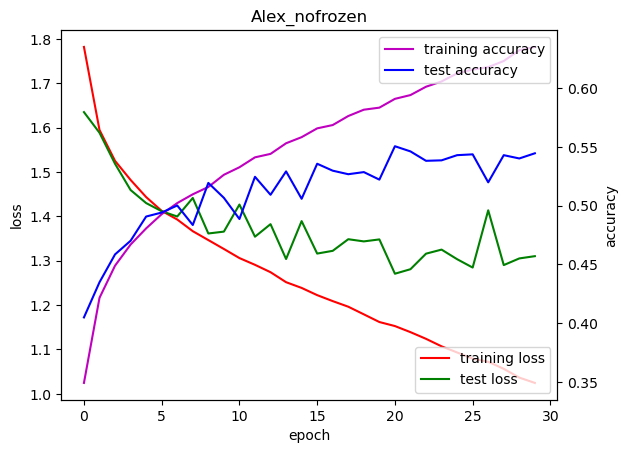

In [60]:
# Your graphs here and please provide comment in markdown in another cell
# plot
alexnet_c1 = alexnet
results_path = "/kaggle/working/Alex_nofrozen"

checkpoint = torch.load(results_path)
alexnet_c1.load_state_dict(checkpoint['state_dict'])

myplot = myPlot(results_path,"Alex_nofrozen")
myplot.plot()

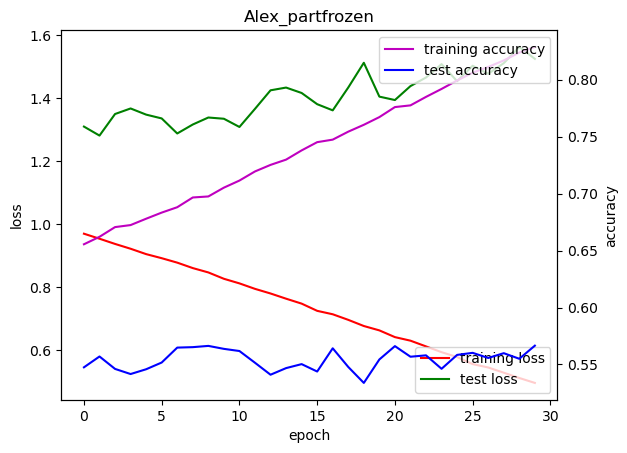

In [61]:
alexnet_c2 = alexnet
results_path = "/kaggle/working/Alex_partfrozen.pt"

checkpoint = torch.load(results_path)
alexnet_c2.load_state_dict(checkpoint['state_dict'])
myplot = myPlot(results_path,"Alex_partfrozen")
myplot.plot()

#### No frozen layers VS Frozen base convolution blocks
Under the same number of training iterations:  
In terms of validation accuracy: Both are about the same, but because the latter freezes some layers, there is almost no change from the beginning to the end, whereas the former has a small upward trend.  
From the perspective of the training set: The latter is better than the former, and the accuracy of the training set for the latter is significantly better than that of the former.  
Overall: There is not much difference between the two for the validation set

### 5 Model comparisons
We often need to compare our model with other state-of-the-art methods to understand how well it performs compared to existing architectures. Here you will thus compare your model design with AlexNet on the TinyImageNet30 dataset

#### 5.1 Finetune AlexNet on TinyImageNet30
> Load AlexNet as you did above

> Train AlexNet on TinyImageNet30 dataset until convergence. Make sure you use the same dataset

In [67]:
# Your code here! 
alexnet_tiny = models.alexnet(pretrained=True)

# Replace the final fully connected layer
num_classes = 30 # number of classes in your dataset
alexnet_tiny.features[0] = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=2)
num_features = alexnet.classifier[6].in_features
alexnet_tiny.classifier[6] = torch.nn.Linear(num_features, num_classes)

alexnet_tiny.eval()

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(alexnet_tiny.parameters(), lr=0.001, momentum=0.9)

results_path = "/kaggle/working/Alex_tinyImage.pt"
nepochs = 30
trainer = Trainer(alexnet_tiny, train_loader, val_loader, optimizer, loss_fn, results_path)
trainer.train(nepochs)


epoch: 0 training loss:  2.966 training accuracy:  16.4%  test loss:  2.592 test accuracy:  25.1%
epoch: 1 training loss:  2.337 training accuracy:  32.3%  test loss:  2.263 test accuracy:  33.9%
epoch: 2 training loss:  1.966 training accuracy:  42.7%  test loss:  1.976 test accuracy:  42.4%
epoch: 3 training loss:  1.691 training accuracy:  50.4%  test loss:  1.791 test accuracy:  47.8%
epoch: 4 training loss:  1.482 training accuracy:  55.1%  test loss:  1.702 test accuracy:  51.0%
epoch: 5 training loss:  1.291 training accuracy:  61.0%  test loss:  1.647 test accuracy:  51.4%
epoch: 6 training loss:  1.113 training accuracy:  65.2%  test loss:  1.713 test accuracy:  51.2%
epoch: 7 training loss:  0.916 training accuracy:  71.5%  test loss:  1.674 test accuracy:  52.3%
epoch: 8 training loss:  0.740 training accuracy:  76.8%  test loss:  1.745 test accuracy:  54.4%
epoch: 9 training loss:  0.576 training accuracy:  81.4%  test loss:  1.839 test accuracy:  53.5%
epoch: 10 training l

#### 5.2 Compare results on validation set of TinyImageNet30
> Loss graph, top1 accuracy, confusion matrix and execution time for your model (say, mymodel and AlexNet)


In [68]:
# Your code here! 
alexnet_tiny = models.alexnet(pretrained=True)

num_classes = 30
alexnet_tiny.features[0] = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=2)
num_features = alexnet.classifier[6].in_features
alexnet_tiny.classifier[6] = torch.nn.Linear(num_features, num_classes)

# alex
alexnet_final = alexnet_tiny
model_path = "/kaggle/working/Alex_tinyImage.pt"
checkpoint = torch.load(model_path)
alexnet_final.load_state_dict(checkpoint['state_dict'])
statsrec_alex = checkpoint["stats"]

# mymodel
myCNN_final = MyCNN()
results_path = "/kaggle/input/mymodels/testcnn50_new.pt"
checkpoint = torch.load(results_path)
myCNN_final.load_state_dict(checkpoint['state_dict'])
statsrec_cnn = checkpoint["stats"]

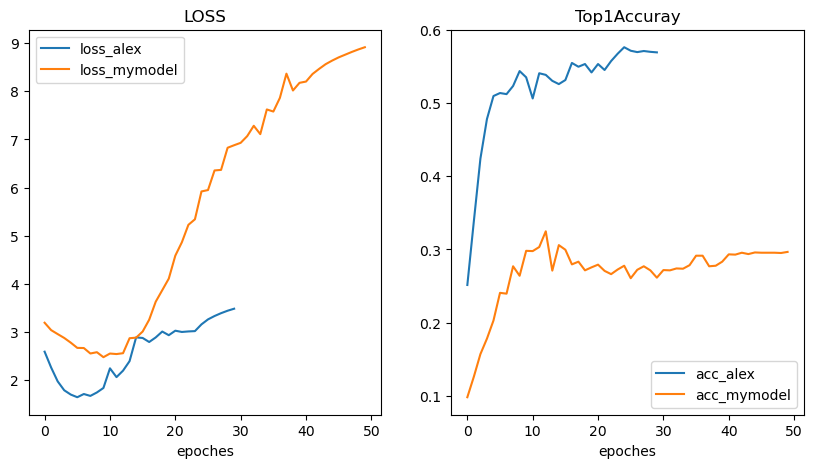

In [69]:
# loss graph, top1 accuracy
# plot
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# plot the first three lists on the first subplot
axs[0].plot(statsrec_alex[2], label='loss_alex')
axs[0].plot(statsrec_cnn[2], label='loss_mymodel')

# customize the first subplot
axs[0].set_title('LOSS')
axs[0].set_xlabel('epoches')
axs[0].legend()

# plot the last three lists on the second subplot
axs[1].plot(statsrec_alex[3], label='acc_alex')
axs[1].plot(statsrec_cnn[3], label='acc_mymodel')

# customize the second subplot
axs[1].set_title('Top1Accuray')
axs[1].set_xlabel('epoches')
axs[1].legend()

# display the plot
plt.show()

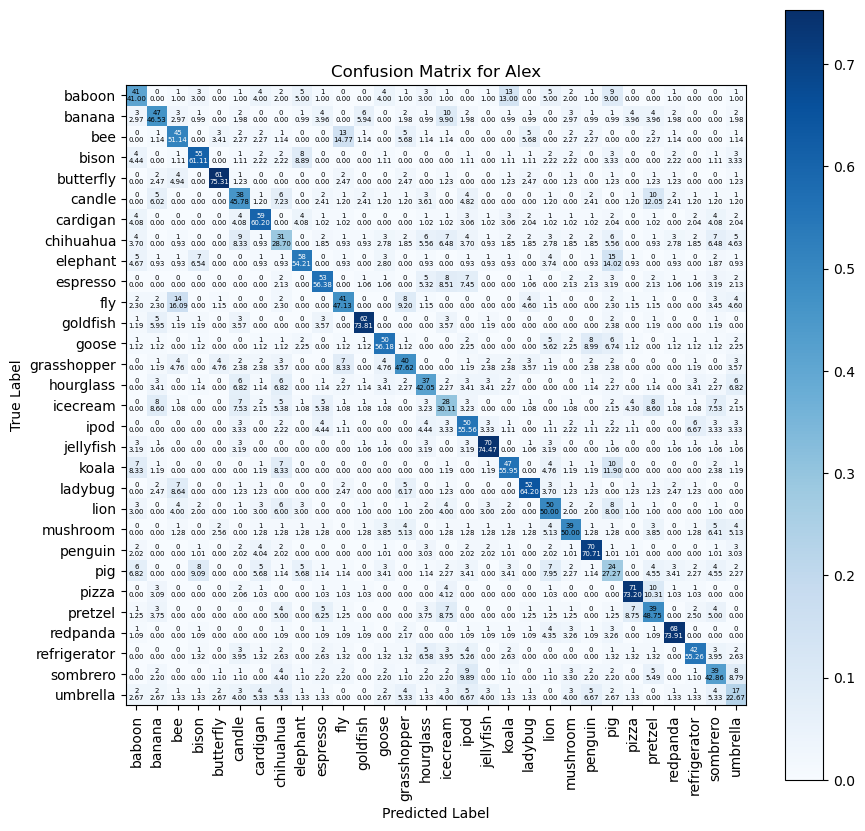

In [71]:
classes = ['baboon', 'banana', 'bee', 'bison', 'butterfly', 'candle', 'cardigan', 'chihuahua', 'elephant', 'espresso', 'fly', 'goldfish', 'goose', 'grasshopper', 'hourglass', 'icecream', 'ipod', 'jellyfish', 'koala', 'ladybug', 'lion', 'mushroom', 'penguin', 'pig', 'pizza', 'pretzel', 'redpanda', 'refrigerator', 'sombrero', 'umbrella']

y_true = []
y_pred = []
alexnet_final = alexnet_final.to(device)

# Make predictions on the validation set and collect the true and predicted labels
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = alexnet_final(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)


cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cm_norm, cmap='Blues')
cbar = ax.figure.colorbar(im, ax=ax)


ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes, rotation=90)
ax.set_yticklabels(classes)


for i in range(len(classes)):
    for j in range(len(classes)):
        ax.text(j, i, format(cm[i, j], 'd')+'\n'+format(cm_norm[i, j]*100, '.2f'),
                ha="center", va="center", fontsize=5, color="white" if cm_norm[i, j] > 0.5 else "black")


ax.set_title("Confusion Matrix for Alex")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

# Display the plot
plt.show()


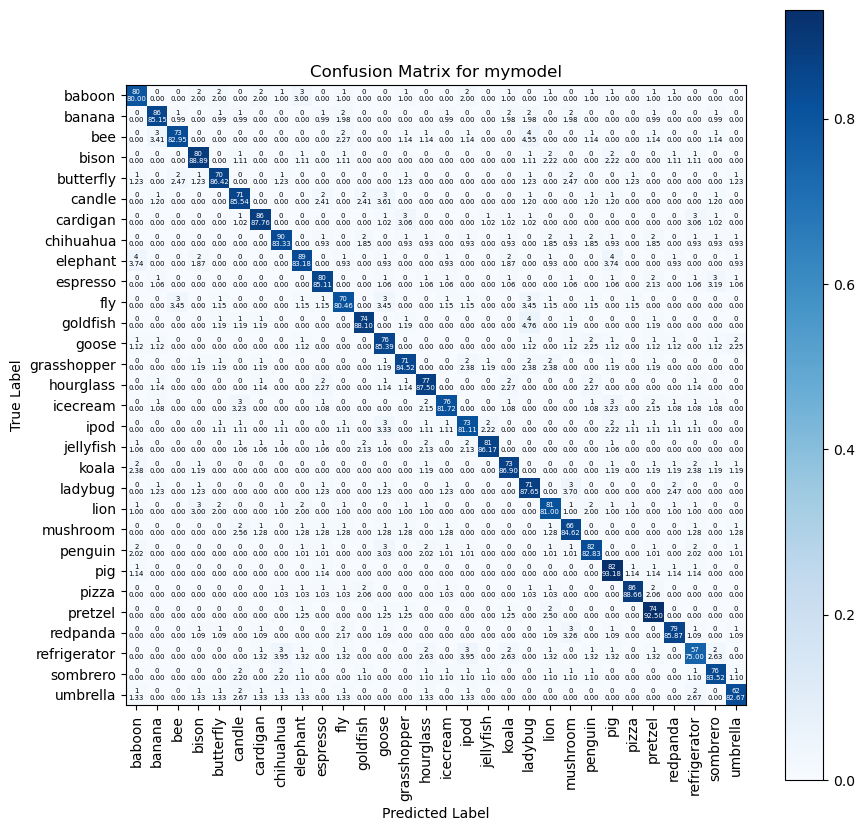

In [72]:
classes = ['baboon', 'banana', 'bee', 'bison', 'butterfly', 'candle', 'cardigan', 'chihuahua', 'elephant', 'espresso', 'fly', 'goldfish', 'goose', 'grasshopper', 'hourglass', 'icecream', 'ipod', 'jellyfish', 'koala', 'ladybug', 'lion', 'mushroom', 'penguin', 'pig', 'pizza', 'pretzel', 'redpanda', 'refrigerator', 'sombrero', 'umbrella']
# Initialize lists to store true and predicted labels
y_true = []
y_pred = []
myCNN_final = myCNN_final.to(device)

# Make predictions on the validation set and collect the true and predicted labels
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = myCNN_final(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10, 10))


im = ax.imshow(cm_norm, cmap='Blues')
cbar = ax.figure.colorbar(im, ax=ax)


ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes, rotation=90)
ax.set_yticklabels(classes)


for i in range(len(classes)):
    for j in range(len(classes)):
        ax.text(j, i, format(cm[i, j], 'd')+'\n'+format(cm_norm[i, j]*100, '.2f'),
                ha="center", va="center", fontsize=5, color="white" if cm_norm[i, j] > 0.5 else "black")

# Set axis labels and title
ax.set_title("Confusion Matrix for mymodel")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

# Display the plot
plt.show()


### Comparation of Alexnet and Mymodel
Honestly, Alexnet works better than my model.
It achieves a higher accuracy than mime.

### 6 Interpretation of results (16 marks)

> Please use TinyImageNet30 dataset for all results


#### 6.1-6.2 Implement grad-CAM and visualise results (10 marks)

- Use an existing library to initiate grad-CAM 

        - To install: !pip install torchcam
        - Call SmoothGradCAMpp: from torchcam.methods import SmoothGradCAMpp
        - Apply to your model 

You can see the details here: https://github.com/frgfm/torch-cam

- Apply grad-CAM to your model on at least four correctly classified images
- Apply grad-CAM on retrained AlexNet on at least four incorrectly classified images

>It is recommended to first read the relevant paper [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391), and refer to relevant course material.


**HINT for displaying images with grad-CAM:**

Display ```heatmap``` as a coloured heatmap superimposed onto the original image. We recommend the following steps to get a clear meaningful display. 

From torchcam.utils import overlay_mask. But remember to resize your image, normalise it and put a 1 for the batch dimension (e.g, [1, 3, 224, 224]) 


In [73]:
# Your code here!
!pip install torchcam
from torchcam.methods import SmoothGradCAMpp

In [74]:
# Your code here!
# mymodel
myCNN_final = MyCNN()
results_path = "/kaggle/input/mymodels/testcnn50_new.pt"
checkpoint = torch.load(results_path)
myCNN_final.load_state_dict(checkpoint['state_dict'])
myCNN_final.eval()

MyCNN(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2704, out_features=256, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=256, out_features=30, bias=True)
  (lossfunction): CrossEntropyLoss()
)

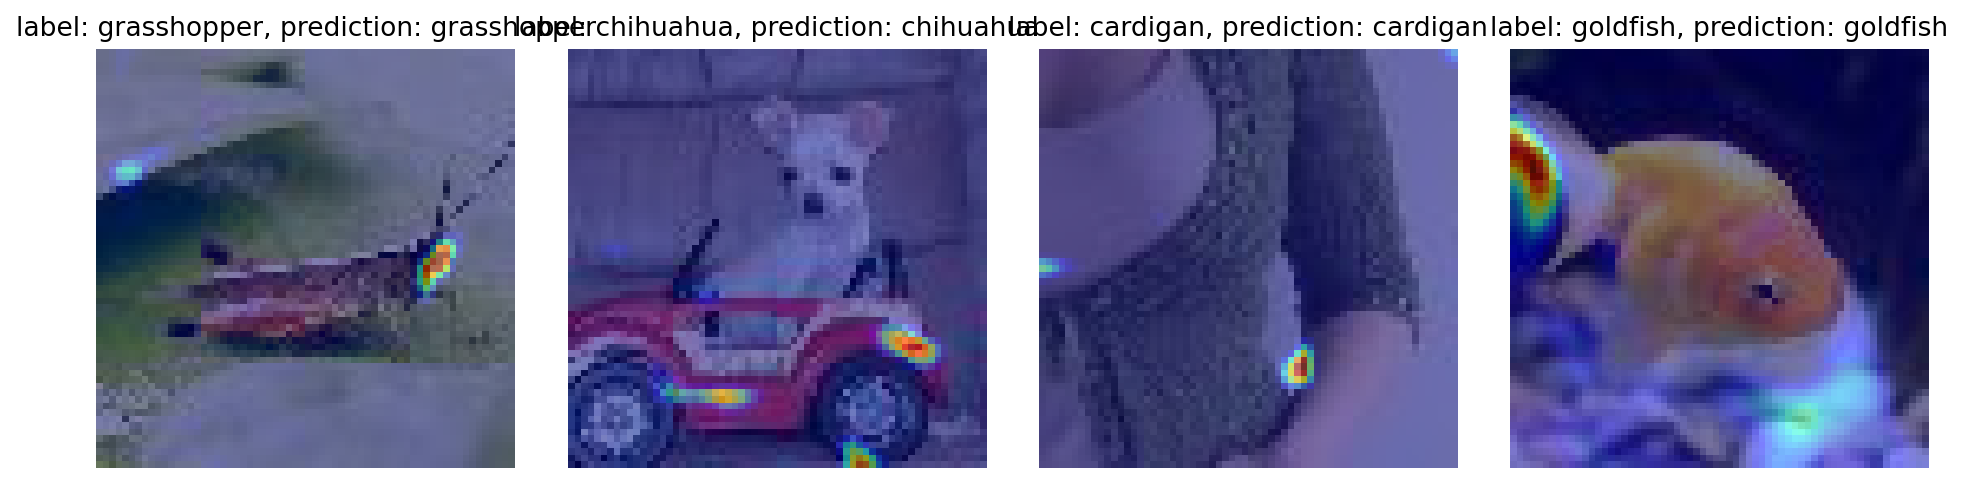

In [85]:
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchcam.utils import overlay_mask
import torchvision.transforms.functional as TF
classes = ['baboon', 'banana', 'bee', 'bison', 'butterfly', 'candle', 'cardigan', 'chihuahua', 'elephant', 'espresso', 'fly', 'goldfish', 'goose', 'grasshopper', 'hourglass', 'icecream', 'ipod', 'jellyfish', 'koala', 'ladybug', 'lion', 'mushroom', 'penguin', 'pig', 'pizza', 'pretzel', 'redpanda', 'refrigerator', 'sombrero', 'umbrella']

transform = transforms.ToTensor()
data_cam = dataset
batch_size = 1
cam_loader = torch.utils.data.DataLoader(data_cam, batch_size = batch_size, shuffle=True)

# 4 correct imgs in mymodel
model = myCNN_final.to(device)
model.eval()

cam = SmoothGradCAMpp(model=model,target_layer = model.conv2)
n = 0
plt.figure(figsize=(12,3),dpi=159)
for data in cam_loader:
    inputs,labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)
    output = model(inputs)
    _,pre = torch.max(output.data,1)
    if n < 4:
#         print(labels)
        if pre == labels:
            n += 1
            heatmap = cam(pre.item(),output)
            result = overlay_mask(to_pil_image(inputs.squeeze(0)),to_pil_image(heatmap[0].squeeze(0), mode='F'), alpha=0.5)
            
            # store images
            inputs = inputs.squeeze(0)
            img_path = "/kaggle/working/correct" + f"image_{n}.jpg"
            pil_image = TF.to_pil_image(inputs)
            pil_image.save(img_path)
            
            plt.subplot(1,4,n)
            plt.imshow(result)
            plt.axis('off')
            plt.title('label: %s, prediction: %s'%(classes[labels.cpu().numpy().item()],classes[pre]))
    else:
        pass

plt.tight_layout()
plt.show()

In [92]:
# alexnet
# Your code here! 
import torchvision.models as models
alexnet = models.alexnet(pretrained=True)

# Replace the final fully connected layer
num_classes = 30
alexnet.features[0] = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=2)
num_features = alexnet.classifier[6].in_features
alexnet.classifier[6] = torch.nn.Linear(num_features, num_classes)            

alexnet_final = alexnet
model_path = "/kaggle/input/mymodels4/Alex_tinyImage.pt"
checkpoint = torch.load(model_path)
alexnet_final.load_state_dict(checkpoint['state_dict'])


<All keys matched successfully>

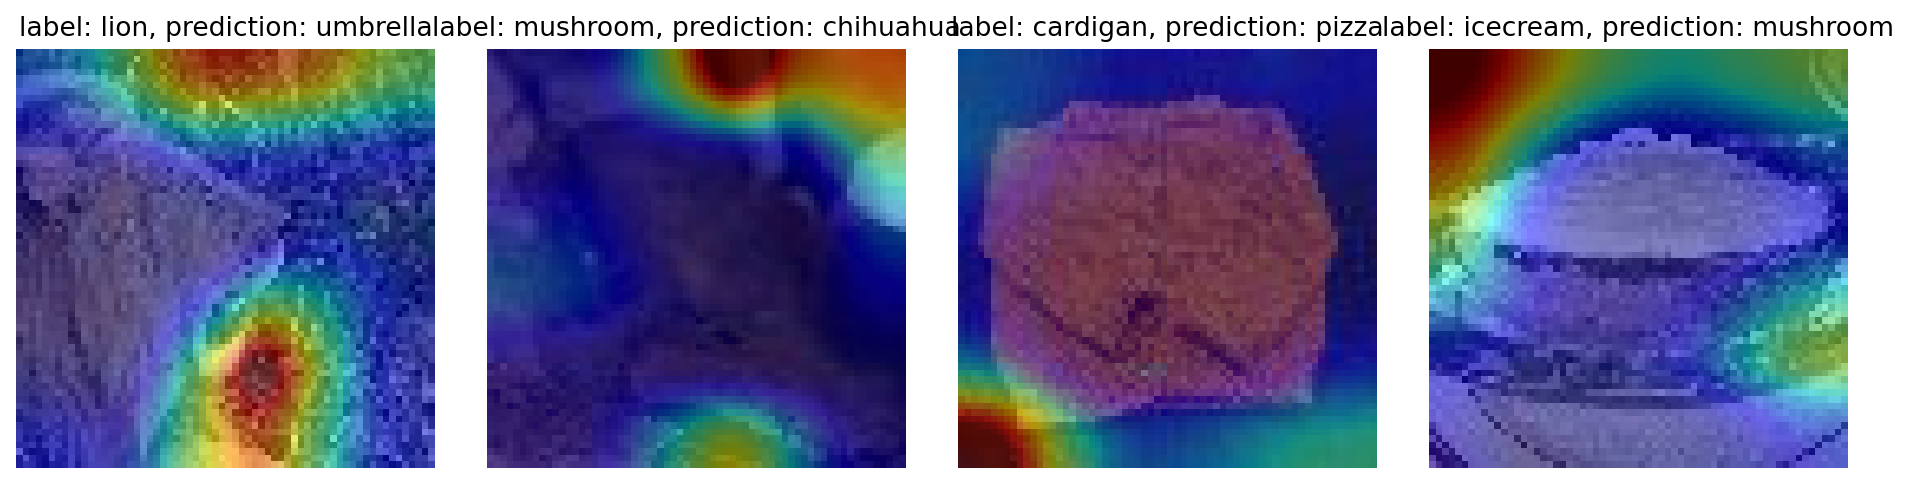

In [93]:
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchcam.utils import overlay_mask
classes = ['baboon', 'banana', 'bee', 'bison', 'butterfly', 'candle', 'cardigan', 'chihuahua', 'elephant', 'espresso', 'fly', 'goldfish', 'goose', 'grasshopper', 'hourglass', 'icecream', 'ipod', 'jellyfish', 'koala', 'ladybug', 'lion', 'mushroom', 'penguin', 'pig', 'pizza', 'pretzel', 'redpanda', 'refrigerator', 'sombrero', 'umbrella']

transform = transforms.ToTensor()
data_cam = dataset
batch_size = 1
cam_loader = torch.utils.data.DataLoader(data_cam, batch_size = batch_size, shuffle=True)


model = alexnet_final.to(device)
model.eval()
cam = SmoothGradCAMpp(model)

flag = 0
plt.figure(figsize=(12,3),dpi=159)
for data in cam_loader:
    inputs,labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)
    output = model(inputs)
    _,pre = torch.max(output.data,1)
    if flag < 4:
        if pre != labels:
            flag = flag + 1
            heatmap = cam(pre.item(),output)
            result = overlay_mask(to_pil_image(inputs.squeeze(0)),to_pil_image(heatmap[0].squeeze(0), mode='F'), alpha=0.5)
            
        
            # store images
            inputs = inputs.squeeze(0)
            img_path = "/kaggle/working/" + f"image_{flag}.jpg"
            pil_image = TF.to_pil_image(inputs)
            pil_image.save(img_path)
            
            
            plt.subplot(1,4,flag)
            plt.imshow(result)
            plt.axis('off')
            plt.title('label: %s, prediction: %s'%(classes[labels.cpu().numpy().item()],classes[pre]))
    else:
        pass

plt.tight_layout()
plt.show()

#### 6.3 Your comments on (6 marks):
> a) Why model predictions were correct or incorrect? You can support your case from 6.2

> b) What can you do to improve your results further?

a) The heatmap helps to visualize where the model has focused its attention. In general, a model's ability to correctly classify an image depends on its ability to focus on the right features of the image. When a model correctly classifies an image, it is because it has identified the key features that distinguish the objective from other objects in the image. Conversely, when a model misclassifies an image, it is often because it has focused on the wrong features.

b) The AlexNet model, which is a highly successful CNN model, can sometimes misclassify images. However, one observation from the heatmap is that the heatmap generated by AlexNet is often larger than the heatmap generated by my model, indicating that it may be able to identify more features of the image. To improve my model, I may need to increase its complexity to allow it to capture more features of the image. In addition, I can explore the use of attention mechanisms, such as Spatial Transformer Networks, Squeeze-and-Excitation Networks, and Global Average Pooling, to help the model focus on the most relevant features of the image.


**Please refer to the submission section at the top of this notebook to prepare your submission. Use our teams channel to seek any help!**
